In [1]:
import pandas as pd
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df_reg = pd.read_csv("prepared_df.csv")

/var/folders/wk/w4dq25x94cg_26_p83q6tnlh0000gn/T/ipykernel_6402/2359597945.py:1: DtypeWarning: Columns (24,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reg = pd.read_csv("prepared_df.csv")


In [3]:
df_reg.head()

,landuse,bldgclass,numbldgs,numfloors,unitsres,unitstotal,lotarea,bldgarea,comarea,resarea,builtfar,residfar,commfar,zipcode,neighborhood,cd,council,schooldist,policeprct,firecomp,healthcenterdistrict,zonedist1,zonedist2,overlay1,overlay2,splitzone,assessland,assesstot,ownertype,yearbuilt,yearalter1,yearalter2,borough,building class category,tax class at present,block,lot,ease-ment,building class at present,apartment number,zip code,residential units,commercial units,total units,land square feet,gross square feet,year built,tax class at time of sale,building class at time of sale,sale price,sale date,buidling_class_num,changed_building_class,sale_date,days_since_2003
0,1.0,A4,1.0,3.0,1.0,1.0,2116.0,4400.0,0.0,3181.0,2.08,4.0,0.0,10009.0,ALPHABET CITY,103.0,2.0,1.0,9.0,E028,14.0,R8B,NaN,NaN,NaN,N,16680.0,77760.0,NaN,1900.0,1989.0,0.0,1,01 ONE FAMILY DWELLINGS,1,374,46,NaN,A4,NaN,10009.0,1.0,0.0,1.0,2116.0,4400.0,1900.0,1,A4,399000.0,2022-09-29 00:00:00,1,0,2022-09-29,7211
1,4.0,S2,1.0,3.0,2.0,3.0,1503.0,2790.0,921.0,1869.0,1.86,4.0,0.0,10009.0,ALPHABET CITY,103.0,2.0,1.0,9.0,L011,14.0,R7A,NaN,C1-5,NaN,N,89400.0,197280.0,NaN,1901.0,0.0,0.0,1,02 TWO FAMILY DWELLINGS,1,377,1,NaN,S2,NaN,10009.0,2.0,1.0,3.0,1502.0,2790.0,1901.0,1,S2,2999999.0,2022-09-15 00:00:00,2,0,2022-09-15,7197
2,2.0,C1,1.0,6.0,10.0,10.0,2204.0,8625.0,0.0,8625.0,3.91,4.0,0.0,10009.0,ALPHABET CITY,103.0,2.0,1.0,9.0,E028,14.0,R8B,NaN,NaN,NaN,N,297000.0,1264500.0,NaN,1899.0,2011.0,0.0,1,07 RENTALS - WALKUP APARTMENTS,2B,373,16,NaN,C1,NaN,10009.0,10.0,0.0,10.0,2204.0,8625.0,1899.0,2,C1,16800000.0,2022-08-04 00:00:00,7,0,2022-08-04,7155
3,2.0,C1,1.0,6.0,10.0,10.0,2204.0,8625.0,0.0,8625.0,3.91,4.0,0.0,10009.0,ALPHABET CITY,103.0,2.0,1.0,9.0,E028,14.0,R8B,NaN,NaN,NaN,N,297000.0,1264500.0,NaN,1900.0,2011.0,0.0,1,07 RENTALS - WALKUP APARTMENTS,2B,373,17,NaN,C1,NaN,10009.0,10.0,0.0,10.0,2204.0,8625.0,1900.0,2,C1,16800000.0,2022-08-04 00:00:00,7,0,2022-08-04,7155
4,2.0,C4,1.0,5.0,20.0,20.0,2302.0,9750.0,0.0,9750.0,4.24,4.0,0.0,10009.0,ALPHABET CITY,103.0,2.0,1.0,9.0,L011,14.0,R8B,NaN,NaN,NaN,N,150750.0,815400.0,X,1900.0,2009.0,0.0,1,07 RENTALS - WALKUP APARTMENTS,2,376,54,NaN,C4,NaN,10009.0,20.0,0.0,20.0,2302.0,9750.0,1900.0,2,C4,158822.0,2022-09-27 00:00:00,7,0,2022-09-27,7209


#### Wybor zmiennych

In [ ]:
num_features = ["numbldgs", "numfloors", "lotarea", "bldgarea", "comarea", "resarea", "builtfar", "residfar", "commfar", "assessland", "assesstot", 'residential units', 'total units', 'year built', 'land square feet', 'gross square feet', "days_since_2003"]
dummy_features = ["landuse", "overlay1", "overlay2", "splitzone", "ownertype", 'tax class at time of sale', 'buidling_class_num']
target_encoding = ["zipcode", "neighborhood", "cd", "council", "schooldist", "policeprct", "firecomp", "healthcenterdistrict", "zonedist1", "zonedist2"]
to_bool = ["yearalter2", "yearalter1", "apartment number", 'changed_building_class']
to_drop = ["bldgclass", "yearbuilt", " zip code", "building class category", "borough", "block", "lot", "ease-ment", "unitsres", "unitstotal", 'commercial units', "tax class at present", "sale date", "building class at time of sale", "sale_date"]
custom_features = ["building class at present"]

kody pocztowe nie dziala jak w polsce - moga pokrywac wiele budynkow

In [ ]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017601 entries, 0 to 1017600
Data columns (total 55 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   landuse                         1017601 non-null  float64       
 1   bldgclass                       1017601 non-null  object        
 2   numbldgs                        1017524 non-null  float64       
 3   numfloors                       1001468 non-null  float64       
 4   unitsres                        1017601 non-null  float64       
 5   unitstotal                      1017601 non-null  float64       
 6   lotarea                         1017524 non-null  float64       
 7   bldgarea                        1017601 non-null  float64       
 8   comarea                         997279 non-null   float64       
 9   resarea                         997279 non-null   float64       
 10  builtfar                        1017392 no

In [ ]:
# Convert to bool (1 if the value is not null and not 0, otherwise 0)
for col in to_bool:
    df_reg[col] = ((df_reg[col].notnull()) & (df_reg[col] != 0)).astype(int)

In [ ]:
# get dummy columns
df_reg = pd.get_dummies(df_reg, columns=dummy_features)

In [ ]:
# dla customowych wybieramy feature ktore maja 90% danych - reszte dajemy do other

def select_top_categories(df, column, threshold=0.9):
    value_counts = df[column].value_counts(normalize=True)  # Get relative frequencies
    cumulative_sum = value_counts.cumsum()  # Compute cumulative sum
    
    # Select categories that cover the threshold percentage of data
    top_categories = cumulative_sum[cumulative_sum <= threshold].index.tolist()
    
    # Ensure at least 5 categories are always selected
    if len(top_categories) < 5:
        top_categories = value_counts.index[:5].tolist()
    
    return top_categories

def process_custom_features(df, top_categories, column):
    df[column] = df[column].apply(
        lambda x: x if x in top_categories else "Other"
    )
    df = pd.get_dummies(df, columns=[column], drop_first=True)
    return df

for col in custom_features:
    top_cat = select_top_categories(df_reg, col)
    df_reg = process_custom_features(df_reg, top_cat, col)

In [ ]:
train_df, temp_df = train_test_split(df_reg, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(df_reg, test_size=0.5, random_state=42)

In [ ]:
target_encoder = TargetEncoder()
train_df[target_encoding] = target_encoder.fit_transform(train_df[target_encoding], train_df["sale price"])
val_df[target_encoding] = target_encoder.transform(val_df[target_encoding])
test_df[target_encoding] = target_encoder.transform(test_df[target_encoding])

In [ ]:
scaler = StandardScaler()
scaler.fit(train_df[num_features])

train_df[num_features] = scaler.transform(train_df[num_features])
val_df[num_features] = scaler.transform(val_df[num_features])
test_df[num_features] = scaler.transform(test_df[num_features])

In [ ]:
train_df.drop(columns=to_drop, inplace=True)
val_df.drop(columns=to_drop, inplace=True)
test_df.drop(columns=to_drop, inplace=True)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814080 entries, 307710 to 121958
Columns: 128 entries, numbldgs to building class at present_S2
dtypes: bool(96), float64(28), int64(4)
memory usage: 279.5 MB


In [ ]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 814080 entries, 307710 to 121958
Data columns (total 128 columns):
 #    Column                           Dtype  
---   ------                           -----  
 0    numbldgs                         float64
 1    numfloors                        float64
 2    lotarea                          float64
 3    bldgarea                         float64
 4    comarea                          float64
 5    resarea                          float64
 6    builtfar                         float64
 7    residfar                         float64
 8    commfar                          float64
 9    zipcode                          float64
 10   neighborhood                     float64
 11   cd                               float64
 12   council                          float64
 13   schooldist                       float64
 14   policeprct                       float64
 15   firecomp                         float64
 16   healthcenterdistrict             flo

In [ ]:
target_column = "sale price"

X_train, y_train = train_df.drop(columns=[target_column]), train_df[target_column]
X_val, y_val = val_df.drop(columns=[target_column]), val_df[target_column]
X_test, y_test = test_df.drop(columns=[target_column]), test_df[target_column]

#### Modele

##### LGBM

In [ ]:
# Now import the required libraries
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,           # controls complexity; adjust based on your data
    'learning_rate': 0.05,      # a smaller learning rate can improve accuracy but requires more rounds
    'feature_fraction': 0.9,    # randomly select part of features on each iteration for robustness
    'bagging_fraction': 0.8,    # randomly select part of data on each iteration for better generalization
    'bagging_freq': 5,          # frequency for bagging; set to 0 to disable
    'verbose': 0
}

In [ ]:
model = lgb.train(
    params,
    train_data,
    num_boost_round=20000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'validation'],
    callbacks=[lgb.early_stopping(300), lgb.log_evaluation(100)]
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 300 rounds
[100]	train's rmse: 7.44254e+06	validation's rmse: 6.93657e+06
[200]	train's rmse: 6.63496e+06	validation's rmse: 6.13472e+06
[300]	train's rmse: 6.13896e+06	validation's rmse: 5.69075e+06
[400]	train's rmse: 5.83212e+06	validation's rmse: 5.38359e+06
[500]	train's rmse: 5.4958e+06	validation's rmse: 5.10909e+06
[600]	train's rmse: 5.32874e+06	validation's rmse: 4.93878e+06
[700]	train's rmse: 5.12946e+06	validation's rmse: 4.77646e+06
[800]	train's rmse: 5.01981e+06	validation's rmse: 4.63247e+06
[900]	train's rmse: 4.88751e+06	validation's rmse: 4.56624e+06
[1000]	train's rmse: 4.74089e+06	validation's rmse: 4.47341e+06
[1100]	train's rmse: 4.59696e+06	validation's rmse: 4.36122e+06
[1200]	train's rmse: 4.501e+06	validation's rmse: 4.28038e+06
[1300]	train's rmse: 4

In [ ]:
y_pred = model.predict(X_val, num_iteration=model.best_iteration)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)
print(rmse, r2)

1519664.946359476 0.9830366371972412


/Users/patryk/venv-torch/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)
r2_test = r2_score(y_test, y_pred_test)
r2_test

0.8223700830845931

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

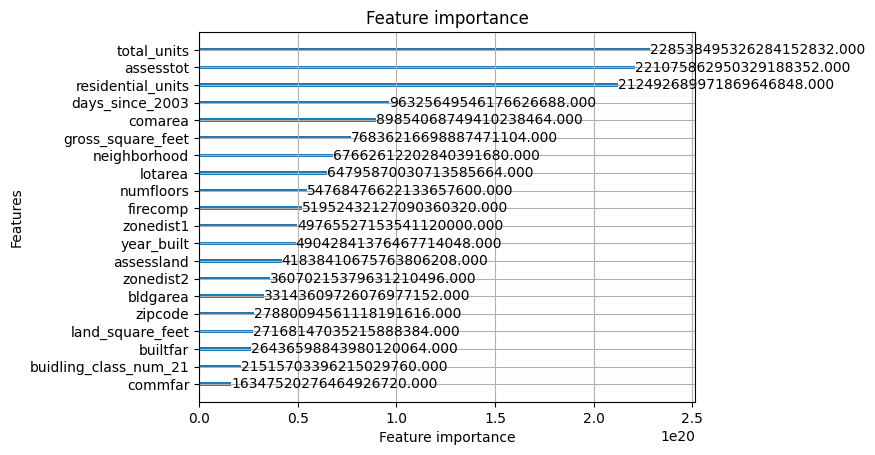

In [ ]:
lgb.plot_importance(model, max_num_features=20, importance_type='gain')

In [ ]:
model_light = lgb.train(
    params,
    train_data,
    num_boost_round=5000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'validation'],
    callbacks=[lgb.early_stopping(300), lgb.log_evaluation(100)]
)

y_pred = model_light.predict(X_val, num_iteration=model_light.best_iteration)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)
print(rmse, r2)

y_pred_test = model_light.predict(X_test, num_iteration=model_light.best_iteration)
r2_test = r2_score(y_test, y_pred_test)
print(r2_test)

Training until validation scores don't improve for 300 rounds
[100]	train's rmse: 7.44254e+06	validation's rmse: 6.93657e+06
[200]	train's rmse: 6.63496e+06	validation's rmse: 6.13472e+06
[300]	train's rmse: 6.13896e+06	validation's rmse: 5.69075e+06
[400]	train's rmse: 5.83212e+06	validation's rmse: 5.38359e+06
[500]	train's rmse: 5.4958e+06	validation's rmse: 5.10908e+06
[600]	train's rmse: 5.32776e+06	validation's rmse: 4.93827e+06
[700]	train's rmse: 5.13135e+06	validation's rmse: 4.78137e+06
[800]	train's rmse: 5.01982e+06	validation's rmse: 4.63681e+06
[900]	train's rmse: 4.89149e+06	validation's rmse: 4.57907e+06
[1000]	train's rmse: 4.74972e+06	validation's rmse: 4.48632e+06
[1100]	train's rmse: 4.60315e+06	validation's rmse: 4.36709e+06
[1200]	train's rmse: 4.49988e+06	validation's rmse: 4.27537e+06
[1300]	train's rmse: 4.4091e+06	validation's rmse: 4.18243e+06
[1400]	train's rmse: 4.34311e+06	validation's rmse: 4.15492e+06
[1500]	train's rmse: 4.26439e+06	validation's rmse: 4

/Users/patryk/venv-torch/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2352966.0043417183 0.9593324916980009
0.8115659597557295


##### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=1,
    early_stopping_rounds=200
)

In [ ]:
model.fit(X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True)

In [ ]:
y_pred = model.predict(X_val)
r2 = r2_score(y_val, y_pred)
r2

0.9530697762304802

In [ ]:
y_pred_test = model.predict(X_test)
r2 = r2_score(y_test, y_pred_test)
r2

0.7361296384878